In [347]:
import numpy as np
import scipy as sp
import pandas as pd
import urllib.request
import os
import shutil
import tarfile
import matplotlib.pyplot as plt
from sklearn import datasets, cross_validation, metrics
from sklearn.preprocessing import KernelCenterer

%matplotlib notebook

First we need to download the Caltech256 dataset.

In [348]:
DATASET_URL = r"http://homes.esat.kuleuven.be/~tuytelaa/"\
"unsup/unsup_caltech256_dense_sift_1000_bow.tar.gz"
DATASET_DIR = "../../../projects/weiyen/data"

In [349]:
filename = os.path.split(DATASET_URL)[1]
dest_path = os.path.join(DATASET_DIR, filename)

if os.path.exists(dest_path):
    print("{} exists. Skipping download...".format(dest_path))
else:
    with urllib.request.urlopen(DATASET_URL) as response, open(dest_path, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
        print("Dataset downloaded. Extracting files...")

tar = tarfile.open(dest_path)
tar.extractall(path=DATASET_DIR)
print("Files extracted.")
tar.close()

path = os.path.join(DATASET_DIR, "bow_1000_dense/")

../../../projects/weiyen/data/unsup_caltech256_dense_sift_1000_bow.tar.gz exists. Skipping download...
Files extracted.


Calculate multi-class KNFST model for multi-class novelty detection
    
    INPUT
      K: NxN kernel matrix containing similarities of n training samples
      labels: Nx1 column vector containing multi-class labels of N training samples

    OUTPUT
      proj: Projection of KNFST
      target_points: The projections of training data into the null space


Load the dataset into memory

In [351]:
ds = datasets.load_files(path)
ds.data = np.vstack([np.fromstring(txt, sep='\t') for txt in ds.data])


In [352]:
data = ds.data
target = ds.target

Select a few "known" classes

In [354]:
classes = np.unique(target)
num_class = len(classes)
num_known = 5

known = np.random.choice(classes, num_known)
mask = np.array([y in known for y in target])

X_train = data[mask]
y_train = target[mask]

idx = y_train.argsort()
X_train = X_train[idx]
y_train = y_train[idx]

print(X_train.shape)
print(y_train.shape)

(538, 1000)
(538,)


In [355]:
def _hik(x, y):
    '''
    Implements the histogram intersection kernel.
    '''
    return np.minimum(x, y).sum()


In [356]:
from scipy.linalg import svd

def nullspace(A, eps=1e-12):
    u, s, vh = svd(A)
    null_mask = (s <= eps)
    null_space = sp.compress(null_mask, vh, axis=0)
    return sp.transpose(null_space)

A = np.array([[2,3,5],[-4,2,3],[0,0,0]])
np.array([-4,2,3]).dot(nullspace(A))

array([  4.44089210e-16])

Train the model, and obtain the projection and class target points.

In [357]:
def learn(K, labels):
    classes = np.unique(labels)
    if len(classes) < 2:
        raise Exception("KNFST requires 2 or more classes")
    n, m = K.shape
    if n != m:
        raise Exception("Kernel matrix must be quadratic")
    
    centered_k = KernelCenterer().fit_transform(K)
    
    basis_values, basis_vecs = np.linalg.eigh(centered_k)
    
    basis_vecs = basis_vecs[:,basis_values > 1e-12]
    basis_values = basis_values[basis_values > 1e-12]
 
    basis_values = np.diag(1.0/np.sqrt(basis_values))

    basis_vecs  = basis_vecs.dot(basis_values)

    L = np.zeros([n,n])
    for cl in classes:
        for idx1, x in enumerate(labels == cl):
            for idx2, y in enumerate(labels == cl):
                if x and y:
                    L[idx1, idx2] = 1.0/np.sum(labels==cl)
    M = np.ones([m,m])/m
    H = (((np.eye(m,m)-M).dot(basis_vecs)).T).dot(K).dot(np.eye(n,m)-L)
    
    t_sw = H.dot(H.T)
    eigenvecs = nullspace(t_sw)
    if eigenvecs.shape[1] < 1:
        eigenvals, eigenvecs = np.linalg.eigh(t_sw)
        
        eigenvals = np.diag(eigenvals)
        min_idx = eigenvals.argsort()[0]
        eigenvecs = eigenvecs[:, min_idx]
    proj = ((np.eye(m,m)-M).dot(basis_vecs)).dot(eigenvecs)
    target_points = []
    for cl in classes:
        k_cl = K[labels==cl, :]        
        pt = np.mean(k_cl.dot(proj), axis=0)
        target_points.append(pt)
        
    return proj, np.array(target_points)

In [358]:
kernel_mat = metrics.pairwise_kernels(X_train, metric=_hik)
proj, target_points = learn(kernel_mat, y_train)

In [375]:
def squared_euclidean_distances(x, y):
    n = np.shape(x)[0]
    m = np.shape(y)[0]
    distmat = np.zeros((n,m))
    
    for i in range(n):
        for j in range(m):
            buff = x[i,:] - y[j,:]
            distmat[i,j] = buff.dot(buff.T)
    return distmat

def assign_score(proj, target_points, ks):
    projection_vectors = ks.T.dot(proj)
    sq_dist = squared_euclidean_distances(projection_vectors, target_points)
    scores = np.sqrt(np.amin(sq_dist, 1))
    return scores



In [379]:
auc_scores = []
classes = np.unique(target)
num_known = 5
for n in range(20):
    num_class = len(classes)
    known = np.random.choice(classes, num_known)
    mask = np.array([y in known for y in target])

    X_train = data[mask]
    y_train = target[mask]
    
    idx = y_train.argsort()
    X_train = X_train[idx]
    y_train = y_train[idx]
    
    sample_idx = np.random.randint(0, len(data), size=1000)
    X_test = data[sample_idx,:]
    y_labels = target[sample_idx]

    # Test labels are 1 if novel, otherwise 0.
    y_test = np.array([1 if cl not in known else 0 for cl in y_labels])
    
    # Train model
    kernel_mat = metrics.pairwise_kernels(X_train, metric=_hik)
    proj, target_points = learn(kernel_mat, y_train)
    
    # Test
    ks = metrics.pairwise_kernels(X_train, X_test, metric=_hik)
    scores = assign_score(proj, target_points, ks)
    auc = metrics.roc_auc_score(y_test, scores)
    print("AUC:", auc)
    auc_scores.append(auc)

    


AUC: 0.269456410256
AUC: 1.0
AUC: 1.0
AUC: 1.0
AUC: 0.272551020408
AUC: 0.990788126919
AUC: 0.501006036217
AUC: 1.0
AUC: 0.809297709105
AUC: 0.4522182861
AUC: 0.502514351831
AUC: 0.228532104602
AUC: 0.32806368427


KeyboardInterrupt: 

In [323]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)

<IPython.core.display.Javascript object>


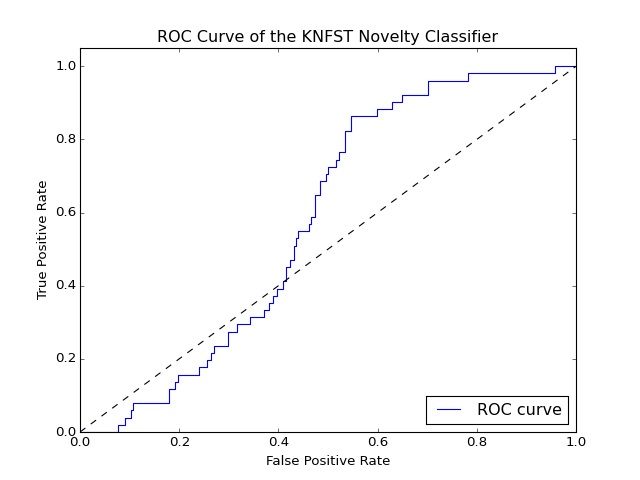

In [324]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of the KNFST Novelty Classifier')
plt.legend(loc="lower right")
plt.show()